## Predição por Suavização Exponencial (ETS)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import rcParams
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from shutil import copy2
import warnings

# Matplotlib options
rcParams['figure.figsize'] = (10, 8)
rcParams['axes.grid'] = False
plt.style.use('seaborn-deep')
%matplotlib inline

# Pandas setup
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_colwidth', -1) 

warnings.filterwarnings('ignore')

In [2]:
# Read file
path = "./datasets/"
name = "p2"
df = pd.read_csv(path + name + "_clipped.csv", encoding='utf8', parse_dates=True, index_col="DATE").resample("M").mean()
validation = pd.read_csv(path + name + "_validation.csv", encoding='utf8', parse_dates=True, index_col="DATE")
cols = df.columns
col = cols[9]

## Método 1 -- Suavização Simples (SES)

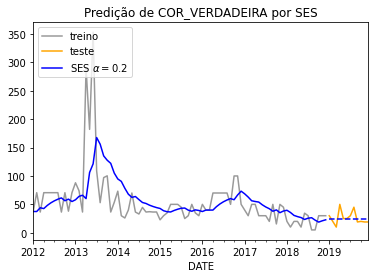

In [3]:
ses_02 = SimpleExpSmoothing(df[col]).fit(smoothing_level=0.2, optimized=False)
ses_predict_02 = ses_02.forecast(12).rename(r"")

# plots
df[col].plot(marker=None, color="grey", alpha=0.8, label="treino")
validation[col].plot(marker=None, color="orange", label="teste")
ses_predict_02.plot(linestyle="--", color="blue")
ses_02.fittedvalues.plot(color="blue", label=r"SES $\alpha=0.2$")
plt.title(f"Predição de {col} por SES")
plt.legend(loc="upper left");

## Método 2 -- Holt (Tendência)

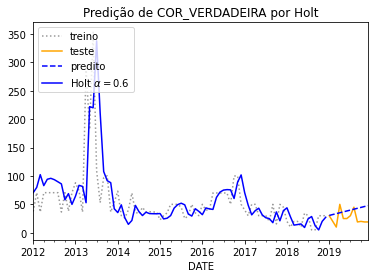

In [4]:
holt_06 = Holt(df[col]).fit(smoothing_level=0.6, smoothing_slope=0.2, optimized=False)
holt_predict_06 = holt_06.forecast(12).rename(r"predito")

# plots
df[col].plot(marker=None, linestyle=":", color="grey", alpha=0.8, label="treino")
validation[col].plot(marker=None, color="orange", label="teste")
holt_predict_06.plot(linestyle="--", color="blue")
holt_06.fittedvalues.plot(marker=None, color="blue", label=r"Holt $\alpha=0.6$")
plt.title(f"Predição de {col} por Holt")
plt.legend(loc="upper left");

## Método 3 -- Predição por Holt Winter (Tendência e Sazonalidade)
Método aplicado utilizando transformação de poder Boxcox (Boxcox Power Transform), que transforma uma distribuição cujos dados não se adequam a uma normal para os de uma normal, possibilitando a execução de mais testes estatísticos.

In [5]:
winter_add = ExponentialSmoothing(df[col], seasonal_periods=4, trend="add", seasonal="add")\
    .fit(use_boxcox=True, smoothing_level=0.6)
predict_add = winter_add.forecast(12).rename("")

winter_tadd_smul = ExponentialSmoothing(df[col], seasonal_periods=4, trend="add", seasonal="mul")\
    .fit(use_boxcox=True, smoothing_level=0.6)
predict_tadd_smul = winter_tadd_smul.forecast(12).rename("")

winter_tmul_sadd = ExponentialSmoothing(df[col], seasonal_periods=4, trend="mul", seasonal="add")\
    .fit(use_boxcox=True, smoothing_level=0.6)
predict_tmul_sadd = winter_tmul_sadd.forecast(12).rename("")

winter_mul = ExponentialSmoothing(df[col], seasonal_periods=4, trend="mul", seasonal="mul")\
    .fit(use_boxcox=True, smoothing_level=0.6)
predict_mul = winter_mul.forecast(12).rename("")

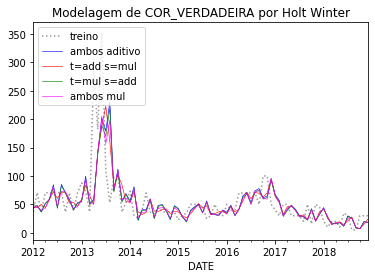

In [6]:
# plot séries
df[col].plot(marker=None, linestyle=":", color="grey", alpha=0.8, label="treino")
winter_add.fittedvalues.plot(linestyle="-", linewidth=0.6, color="blue", label="ambos aditivo")
winter_tadd_smul.fittedvalues.plot(linestyle="-", linewidth=0.6, color="red", label="t=add s=mul")
winter_tmul_sadd.fittedvalues.plot(linestyle="-", linewidth=0.6, color="green", label="t=mul s=add")
winter_mul.fittedvalues.plot(linestyle="-", linewidth=0.6, color="magenta", label="ambos mul")
plt.title(f"Modelagem de {col} por Holt Winter")
plt.legend(loc="upper left");

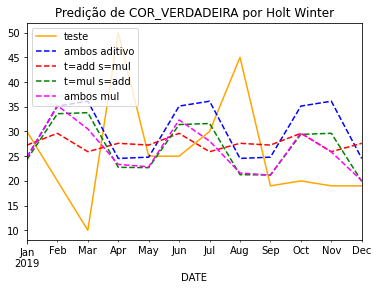

In [7]:
# plot predições
validation[col].plot(marker=None, color="orange", label="teste")
predict_add.plot(linestyle="--", color="blue", label="ambos aditivo")
predict_tadd_smul.plot(linestyle="--", color="red", label="t=add s=mul")
predict_tmul_sadd.plot(linestyle="--", color="green", label="t=mul s=add")
predict_mul.plot(linestyle="--", color="magenta", label="ambos mul")
plt.title(f"Predição de {col} por Holt Winter")
plt.legend(loc="upper left");

## Validação

In [8]:
test_metrics = pd.DataFrame({
    "ses_02": rmse(df[col], ses_02.fittedvalues),
    "holt": rmse(df[col], holt_06.fittedvalues),
    "winter_add": rmse(df[col], winter_add.fittedvalues),
    "winter_tadd_smul": rmse(df[col], winter_tadd_smul.fittedvalues),
    "winter_tmul_sadd": rmse(df[col], winter_tmul_sadd.fittedvalues),
    "winter_mul": rmse(df[col], winter_mul.fittedvalues)
}, index=["RMSE"])
print("Melhor modelo TREINO:")
test_metrics = test_metrics.T.sort_values("RMSE")
test_metrics

Melhor modelo TREINO:


,RMSE
winter_mul,39.719996
winter_tadd_smul,40.543353
winter_tmul_sadd,41.165580
winter_add,41.287749
ses_02,44.918480
holt,47.676237


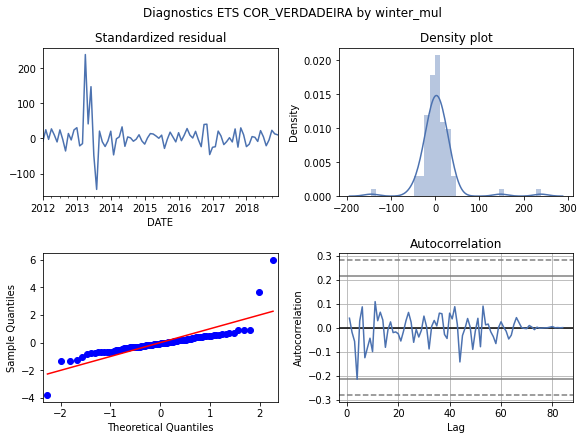

In [9]:
best_fit_name = test_metrics.index[0]
best_fit = eval(best_fit_name)
best_fit_residuals = best_fit.resid

fig, axs = plt.subplots(2, 2, constrained_layout=True)
fig.set_figheight(6)
fig.set_figwidth(8)

ax0 = best_fit_residuals.plot(ax=axs[0,0])
ax1 = sns.distplot(best_fit_residuals, ax=axs[0, 1])
ax2 = qqplot(best_fit_residuals, ax=axs[1, 0], fit=True, line="s")
ax3 = pd.plotting.autocorrelation_plot(best_fit_residuals.values, ax=axs[1, 1])

ax0.title.set_text("Standardized residual")
ax1.title.set_text("Density plot")
# ax2.title.set_text("Q-Q plot")
ax3.title.set_text("Autocorrelation")

plt.suptitle(f"Diagnostics ETS {col} by {best_fit_name}");

In [10]:
validation_metrics = pd.DataFrame({
    "ses": rmse(validation[col], ses_predict_02),
    "holt": rmse(validation[col], holt_predict_06),
    "winter_add": rmse(validation[col], predict_add),
    "winter_tadd_smul": rmse(validation[col], predict_tadd_smul),
    "winter_tmul_sadd": rmse(validation[col], predict_tmul_sadd),
    "winter_mul": rmse(validation[col], predict_mul)
}, index=["RMSE"])
print("Melhor modelo PREDIÇÃO:")
validation_metrics.T.sort_values("RMSE")

Melhor modelo PREDIÇÃO:


,RMSE
winter_tadd_smul,11.116466
ses,11.116868
winter_mul,13.382149
winter_tmul_sadd,13.983363
winter_add,15.090297
holt,18.470789


In [11]:
ets = best_fit.forecast(12)
ets.name = col
%store ets

Stored &#39;ets&#39; (Series)


In [12]:
true_values = validation[col]
true_values.name = col
%store name 
%store true_values

Stored &#39;name&#39; (str)
Stored &#39;true_values&#39; (Series)


In [13]:
copy2("ets.ipynb", f"./models/ets/{name}_{col}.ipynb")

&#39;./models/ets/p2_COR_VERDADEIRA.ipynb&#39;